# Imports

In [25]:
from pathlib import Path
from torchvision.datasets import ImageFolder
from argparse import Namespace
import torch
from torchvision import transforms
import random
from torch.utils.data import Subset
from diffusers import DDIMScheduler
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("bmh")


In [2]:
args = Namespace(
    train_data_dir="/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced",
    split="train",
    resolution=128,
    perc_samples=10,
    seed=42,
)


In [3]:
dataset: ImageFolder = ImageFolder(
    root=Path(args.train_data_dir, args.split).as_posix(),
    transform=lambda x: augmentations(x.convert("RGB")),
    target_transform=lambda y: torch.tensor(y).long(),
)

augmentations = transforms.Compose(
    [
        transforms.Resize(
            args.resolution, interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # map to [-1, 1] for SiLU
    ]
)


In [4]:
dataset


Dataset ImageFolder
    Number of datapoints: 26960
    Root location: /projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train
    StandardTransform
Transform: <function <lambda> at 0x7f65a6fba950>
Target transform: <function <lambda> at 0x7f65a6fbab00>

# Test

In [5]:
# 1. First test if the dataset is balanced; for now we assume it is
class_counts = dict.fromkeys([dataset.class_to_idx[cl] for cl in dataset.classes], 0)
for _, label in dataset.samples:
    class_counts[label] += 1

nb_classes = len(class_counts)

assert (
    list(class_counts.values()) == [class_counts[0]] * nb_classes
), "The dataset is not balanced between classes"

# 2. Then manually sample <perc_samples>% of each class
orig_nb_samples_per_balanced_classes = class_counts[0]

nb_selected_samples_per_class = int(
    orig_nb_samples_per_balanced_classes * args.perc_samples / 100
)

sample_indices = []

nb_selected_samples = dict.fromkeys(
    [dataset.class_to_idx[cl] for cl in dataset.classes], 0
)

# set seed
# `random` is only used here, for the dataset subsampling
random.seed(args.seed)

# random.sample(x, len(x)) shuffles x out-of-place
iterable = random.sample(list(enumerate(dataset.samples)), len(dataset))

for idx, (_, class_label) in iterable:
    # stop condition
    if (
        list(nb_selected_samples.values())
        == [nb_selected_samples_per_class] * nb_classes
    ):
        break
    # select sample
    if nb_selected_samples[class_label] < nb_selected_samples_per_class:
        sample_indices.append(idx)
        nb_selected_samples[class_label] += 1

assert (
    len(sample_indices) == nb_selected_samples_per_class * nb_classes
), "Something went wrong in the subsampling..."

# 3. Return the subset
subset = Subset(dataset, sample_indices)
# hacky but ok to do this because each class is present in the subset
subset.classes = dataset.classes

In [6]:
subset[0]

(tensor([[[-0.7333, -0.6784, -0.6627,  ..., -0.9686, -1.0000, -1.0000],
          [-0.6863, -0.6471, -0.6627,  ..., -0.9686, -0.8902, -0.9294],
          [-0.6549, -0.6863, -0.6863,  ..., -0.9294, -0.9294, -0.9373],
          ...,
          [-0.9373, -0.9137, -0.9059,  ..., -0.9373, -0.8980, -0.8902],
          [-0.9294, -0.9137, -0.8902,  ..., -0.9294, -0.9059, -0.9294],
          [-0.8824, -0.8980, -0.9059,  ..., -0.9529, -0.9608, -0.9137]],
 
         [[-0.3961, -0.4275, -0.4353,  ..., -0.9843, -0.9843, -0.9843],
          [-0.4353, -0.4431, -0.4196,  ..., -0.9843, -0.9843, -0.9765],
          [-0.4980, -0.4980, -0.4824,  ..., -0.9765, -0.9765, -0.9765],
          ...,
          [-0.9451, -0.9294, -0.9059,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9294, -0.9216, -0.8980,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9294, -0.9059, -0.8667,  ..., -0.9686, -0.9608, -0.9608]],
 
         [[-0.9686, -0.9451, -0.9137,  ..., -0.8667, -0.9294, -0.9451],
          [-0.9216, -0.9216,

In [7]:
subset[687]

(tensor([[[-0.1765, -0.1686, -0.1529,  ..., -0.3412, -0.2941, -0.2471],
          [-0.2314, -0.2235, -0.2314,  ..., -0.3176, -0.2471, -0.2078],
          [-0.2392, -0.2471, -0.2784,  ..., -0.2549, -0.1922, -0.1451],
          ...,
          [-0.2706, -0.1922, -0.1451,  ..., -0.1137, -0.0824, -0.0275],
          [-0.1922, -0.1451, -0.0824,  ..., -0.1216, -0.0039,  0.0353],
          [-0.1765, -0.1059, -0.0667,  ..., -0.0667, -0.0196,  0.0275]],
 
         [[-0.5765, -0.6157, -0.4667,  ...,  0.0824, -0.0588, -0.1765],
          [-0.4902, -0.4824, -0.5451,  ...,  0.1451,  0.0275, -0.0745],
          [-0.4588, -0.4118, -0.4902,  ...,  0.1608, -0.0196, -0.0980],
          ...,
          [-0.0353, -0.0588, -0.0980,  ..., -0.1373, -0.1922, -0.1216],
          [-0.0510, -0.1608, -0.2392,  ..., -0.1765, -0.2157, -0.2235],
          [-0.1765, -0.2627, -0.2941,  ..., -0.2235, -0.2000, -0.1529]],
 
         [[-0.9529, -0.9765, -0.9922,  ..., -0.2235, -0.1137, -0.0118],
          [-0.9529, -0.9608,

In [8]:
classes = {0: 0, 1: 0}

for img in subset:
    classes[img[1].item()] += 1

classes


{0: 1348, 1: 1348}

In [9]:
type(subset[0])


tuple

In [10]:
dir(subset)


['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'classes',
 'dataset',
 'indices']

In [11]:
dataset.samples


[('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train/DMSO/Week10_40111_B02_1_100_1203.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train/DMSO/Week10_40111_B02_1_100_1203_flip1rot2.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train/DMSO/Week10_40111_B02_1_100_1203_flip1rot3.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train/DMSO/Week10_40111_B02_1_100_1203_flip2rot2.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train/DMSO/Week10_40111_B02_1_100_1203_flip2rot3.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train/DMSO/Week10_40111_B02_1_100_1203_rot1.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train/DMSO/Week10_40111_B02_1_100_1203_rot2.png',
  0),
 ('/p

In [12]:
dir(dataset)


['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_transform_repr',
 '_is_protocol',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'find_classes',
 'imgs',
 'loader',
 'make_dataset',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']

In [13]:
import numpy as np


In [14]:
subset.targets = [subset.dataset.targets[i] for i in subset.indices]


In [15]:
cl = 0
cl_idxes = np.nonzero(np.array(subset.targets) == cl)[0]
print(cl_idxes)

subsubset = Subset(subset, list(cl_idxes))
subsubset


[   1    2    4 ... 2693 2694 2695]


In [16]:
len(subsubset)


1348

In [17]:
len(dataset)


26960

In [18]:
len(subset)


2696

In [19]:
args.perc_samples


10

In [38]:
raw_transformations = transforms.Compose(
    [
        transforms.Resize(
            args.resolution, interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.PILToTensor(),
    ]
)

from typing import Any, Callable, Optional
from torchvision.datasets import DatasetFolder
from PIL import Image
from torchvision.datasets.folder import default_loader


class RawDataset(ImageFolder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            sample
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        return sample


raw_dataset = RawDataset(
    root=Path(args.train_data_dir, args.split).as_posix(),
    transform=lambda x: raw_transformations(x.convert("RGB")),
)

In [39]:
raw_dataset

Dataset RawDataset
    Number of datapoints: 26960
    Root location: /projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced/train
    StandardTransform
Transform: <function <lambda> at 0x7f65943aab90>

In [40]:
for x in raw_dataset:
    print(x)
    break

tensor([[[ 74,  72,  69,  ...,  95,  81,  79],
         [ 77,  74,  73,  ...,  91,  87,  81],
         [ 80,  74,  73,  ...,  87,  85,  85],
         ...,
         [117, 118, 116,  ...,  56,  57,  56],
         [119, 121, 117,  ...,  48,  47,  50],
         [120, 121, 126,  ...,  46,  44,  43]],

        [[132, 112, 103,  ...,  41,  38,  37],
         [141, 136, 119,  ...,  37,  33,  46],
         [150, 145, 130,  ...,  42,  41,  39],
         ...,
         [ 94,  92,  92,  ..., 109, 108, 118],
         [ 97,  88,  90,  ..., 113, 114, 109],
         [115, 110, 104,  ..., 110, 118, 127]],

        [[105, 130, 150,  ...,   5,   5,   0],
         [ 97, 128, 158,  ...,   4,   5,   4],
         [ 97, 123, 153,  ...,   2,   5,   2],
         ...,
         [ 28,  22,  20,  ...,   3,   6,   6],
         [ 15,  11,   8,  ...,   0,   0,   1],
         [ 12,  14,  12,  ...,   0,   5,   5]]], dtype=torch.uint8)


# Scheduler tests

In [361]:
noise_scheduler_config = {
    "_class_name": "DDIMScheduler",
    "_diffusers_version": "0.18.2",
    "beta_schedule": "scaled_linear",
    "beta_end": 0.015,
    "beta_start": 0.00001,
    "num_train_timesteps": 3000,
    "prediction_type": "v_prediction",
    "rescale_betas_zero_snr": True,
    "timestep_spacing": "trailing",
}

In [362]:
linear_config = noise_scheduler_config.copy()
linear_config["beta_schedule"] = "linear"

cosine_config = noise_scheduler_config.copy()
cosine_config["beta_schedule"] = "squaredcos_cap_v2"

In [363]:
nb_timesteps = 100

In [364]:
noise_scheduler.timesteps

tensor([2999, 2969, 2939, 2909, 2879, 2849, 2819, 2789, 2759, 2729, 2699, 2669,
        2639, 2609, 2579, 2549, 2519, 2489, 2459, 2429, 2399, 2369, 2339, 2309,
        2279, 2249, 2219, 2189, 2159, 2129, 2099, 2069, 2039, 2009, 1979, 1949,
        1919, 1889, 1859, 1829, 1799, 1769, 1739, 1709, 1679, 1649, 1619, 1589,
        1559, 1529, 1499, 1469, 1439, 1409, 1379, 1349, 1319, 1289, 1259, 1229,
        1199, 1169, 1139, 1109, 1079, 1049, 1019,  989,  959,  929,  899,  869,
         839,  809,  779,  749,  719,  689,  659,  629,  599,  569,  539,  509,
         479,  449,  419,  389,  359,  329,  299,  269,  239,  209,  179,  149,
         119,   89,   59,   29])

In [365]:
noise_scheduler.alphas_cumprod[noise_scheduler.timesteps]

tensor([0.0000e+00, 2.4235e-04, 9.7020e-04, 2.1828e-03, 3.8791e-03, 6.0573e-03,
        8.7153e-03, 1.1851e-02, 1.5460e-02, 1.9540e-02, 2.4087e-02, 2.9097e-02,
        3.4564e-02, 4.0483e-02, 4.6848e-02, 5.3653e-02, 6.0893e-02, 6.8558e-02,
        7.6643e-02, 8.5140e-02, 9.4039e-02, 1.0333e-01, 1.1301e-01, 1.2307e-01,
        1.3349e-01, 1.4426e-01, 1.5539e-01, 1.6684e-01, 1.7863e-01, 1.9072e-01,
        2.0311e-01, 2.1580e-01, 2.2875e-01, 2.4198e-01, 2.5545e-01, 2.6916e-01,
        2.8309e-01, 2.9724e-01, 3.1158e-01, 3.2611e-01, 3.4080e-01, 3.5565e-01,
        3.7064e-01, 3.8576e-01, 4.0098e-01, 4.1630e-01, 4.3171e-01, 4.4718e-01,
        4.6270e-01, 4.7826e-01, 4.9384e-01, 5.0942e-01, 5.2500e-01, 5.4055e-01,
        5.5606e-01, 5.7152e-01, 5.8691e-01, 6.0221e-01, 6.1742e-01, 6.3251e-01,
        6.4747e-01, 6.6229e-01, 6.7695e-01, 6.9144e-01, 7.0575e-01, 7.1985e-01,
        7.3374e-01, 7.4741e-01, 7.6083e-01, 7.7400e-01, 7.8691e-01, 7.9953e-01,
        8.1187e-01, 8.2390e-01, 8.3562e-

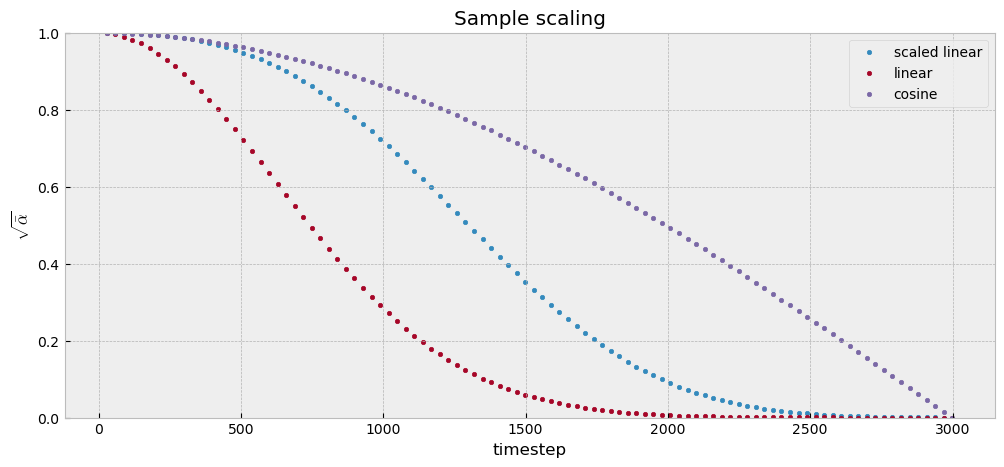

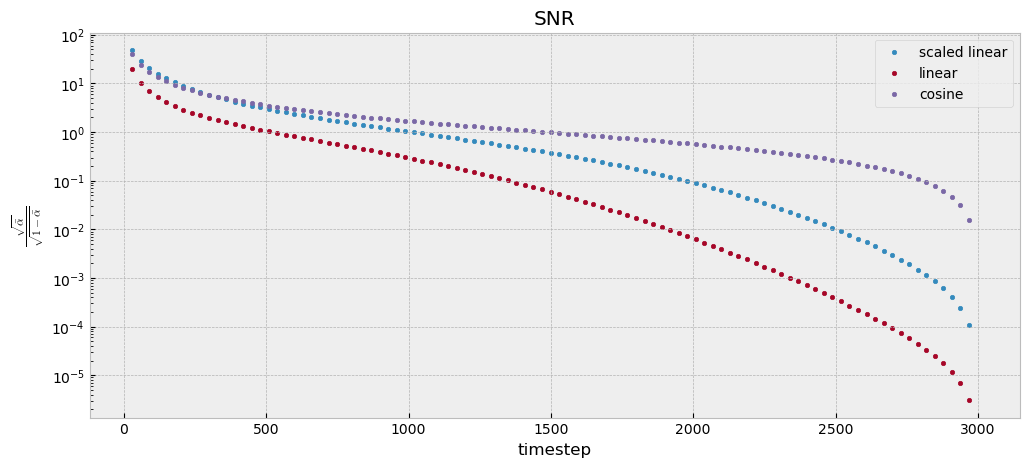

In [366]:
plt.figure(figsize=(12, 5))
for config in [noise_scheduler_config, linear_config, cosine_config]:
    noise_scheduler = DDIMScheduler.from_config(config)
    noise_scheduler.set_timesteps(nb_timesteps)
    plt.scatter(
        noise_scheduler.timesteps,
        np.sqrt(noise_scheduler.alphas_cumprod)[noise_scheduler.timesteps],
        10,
    )
plt.xlabel("timestep")
plt.legend(["scaled linear", "linear", "cosine"])
plt.ylabel(r"$\sqrt{\bar{\alpha}}$")
plt.ylim(0, 1)
plt.title("Sample scaling")
plt.show()

plt.figure(figsize=(12, 5))
for config in [noise_scheduler_config, linear_config, cosine_config]:
    noise_scheduler = DDIMScheduler.from_config(config)
    noise_scheduler.set_timesteps(nb_timesteps)
    plt.scatter(
        noise_scheduler.timesteps,
        np.sqrt(noise_scheduler.alphas_cumprod[noise_scheduler.timesteps])
        / np.sqrt(1 - noise_scheduler.alphas_cumprod[noise_scheduler.timesteps]),
        10,
    )
plt.xlabel("timestep")
plt.legend(["scaled linear", "linear", "cosine"])
plt.ylabel(r"$\frac{\sqrt{\bar{\alpha}}}{\sqrt{1 - \bar{\alpha}}}$")
plt.yscale("log")
plt.title("SNR")
plt.show()

# Dataset tests

In [29]:
from datasets import load_dataset
from torchvision import transforms
import torch

In [37]:
dataset = load_dataset(
    "imagefolder",
    data_dir="/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced",
    drop_labels=False,
    split="train",
)

Resolving data files:   0%|          | 0/26960 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3008 [00:00<?, ?it/s]

Found cached dataset imagefolder (/users/biocomp/tboyer/.cache/huggingface/datasets/imagefolder/default-77bd631b68a5c8aa/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [38]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 26960
})

In [50]:
preproc = transforms.Compose(
    [
        transforms.Resize(
            128,
            interpolation=transforms.InterpolationMode.BILINEAR,
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # map to [-1, 1] for SiLU
    ]
)


def transform_images(examples):
    images = [preproc(image.convert("RGB")) for image in examples["image"]]
    filenames_suffix = [
        image.filename.split("/")[-1].split(".")[0] for image in examples["image"]
    ]
    class_labels = torch.tensor(examples["label"]).long()
    return {
        "images": images,
        "filenames_suffix": filenames_suffix,
        "class_labels": class_labels,
    }


dataset.set_transform(transform_images)


In [55]:
next(iter(dataset))

{'images': tensor([[[-0.4196, -0.4353, -0.4588,  ..., -0.2549, -0.3647, -0.3804],
          [-0.3961, -0.4196, -0.4275,  ..., -0.2863, -0.3176, -0.3647],
          [-0.3725, -0.4196, -0.4275,  ..., -0.3176, -0.3333, -0.3333],
          ...,
          [-0.0824, -0.0745, -0.0902,  ..., -0.5608, -0.5529, -0.5608],
          [-0.0667, -0.0510, -0.0824,  ..., -0.6235, -0.6314, -0.6078],
          [-0.0588, -0.0510, -0.0118,  ..., -0.6392, -0.6549, -0.6627]],
 
         [[ 0.0353, -0.1216, -0.1922,  ..., -0.6784, -0.7020, -0.7098],
          [ 0.1059,  0.0667, -0.0667,  ..., -0.7098, -0.7412, -0.6392],
          [ 0.1765,  0.1373,  0.0196,  ..., -0.6706, -0.6784, -0.6941],
          ...,
          [-0.2627, -0.2784, -0.2784,  ..., -0.1451, -0.1529, -0.0745],
          [-0.2392, -0.3098, -0.2941,  ..., -0.1137, -0.1059, -0.1451],
          [-0.0980, -0.1373, -0.1843,  ..., -0.1373, -0.0745, -0.0039]],
 
         [[-0.1765,  0.0196,  0.1765,  ..., -0.9608, -0.9608, -1.0000],
          [-0.2392